In [183]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import gseapy
from gseapy.plot import barplot, dotplot
import networkx as nx
import OmicsIntegrator as oi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import community 
import pickle
import itertools
from upsetplot import from_contents, UpSet

import get_binarized_map_of_selected_loci_2 as diff

In [324]:
# Reload modules in case of modifications
reload(diff)

<module 'get_binarized_map_of_selected_loci_2' from '/home/braunger/masterthesis/python_code/compare_hic/get_binarized_map_of_selected_loci_2.py'>

In [5]:
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'
data_dir = '/home/braunger/masterthesis/data/'

# 1. Number of intermingling regions per chromosome pair

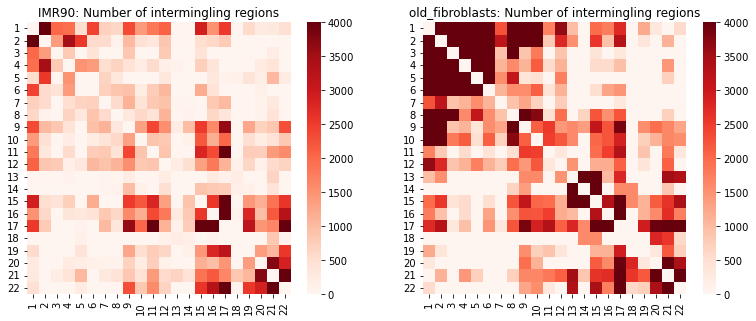

In [262]:
chr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
diff.plot_intermingling_regions(chr_list, hic_dir, "IMR90", 'intermingling_regions', 15, axs[0])
diff.plot_intermingling_regions(chr_list, hic_dir, "old_fibroblasts", 'intermingling_regions', 30, axs[1])
plt.savefig(fig_dir + 'intermingling_regions.png')
plt.show()

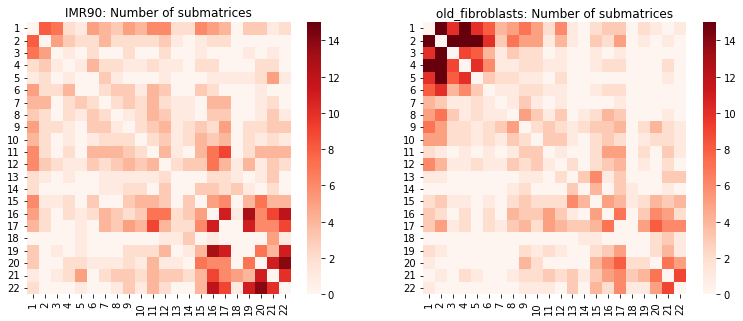

In [263]:
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
diff.plot_intermingling_regions(chr_list, hic_dir, "IMR90", 'LAS', 15, axs[0])
diff.plot_intermingling_regions(chr_list, hic_dir, "old_fibroblasts", 'LAS', 30, axs[1])
plt.savefig(fig_dir + 'submatrices.png')
plt.show()

In [354]:
chr_list = [1,2,3]
young_statistics = diff.LAS_statistics(chr_list, hic_dir, 'IMR90', 15)
old_statistics = diff.LAS_statistics(chr_list, hic_dir, 'old_fibroblasts', 30)

print('For young fibroblasts there are ', int(young_statistics['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_statistics['LAS'].sum()), ' submatrices.')
print('For old fibroblasts there are ', int(old_statistics['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_statistics['LAS'].sum()), ' submatrices.')

For young fibroblasts there are  7702  intermingling regions  and  20  submatrices.
For old fibroblasts there are  57646  intermingling regions  and  51  submatrices.


# 2. Binarized maps for BACH2 targets

In [264]:
# load target loci of BACH2 and add annotation whether target is DE
selected_loci = pd.read_csv(save_dir + 'TF_targets/BACH2_targets_loci.csv')
DE_genes = pd.read_csv(data_dir + 'de_data/DE_var_p_n_200.csv')
DE_genes['DE'] = 'True'
DE_genes = DE_genes[['gene', 'DE']]

selected_loci = selected_loci.merge(DE_genes, how = "left")
selected_loci['DE'] = selected_loci['DE'].fillna('False')
selected_loci.head()

BACH2_locus = selected_loci.loc[selected_loci['gene'] == "BACH2", 'locus'].item()

# load TF targets
tf_targets = pd.read_csv(save_dir + 'TF_targets/' + 'TF_targets_anno.csv', sep = ',')

In [327]:
tf_targets.head()

,TF,target,DE,expressed,locus,young_activity,old_activity,development
0,AEBP2,TMEM53,False,True,chr_1_loc_44500000,young:active,old:active,young:active_old:active
1,AEBP2,FBXO31,False,True,chr_16_loc_87250000,young:active,old:active,young:active_old:active
2,AEBP2,ADAMTSL5,False,True,chr_19_loc_1500000,young:active,old:active,young:active_old:active
3,AEBP2,MIR6791,False,False,chr_19_loc_6500000,young:active,old:active,young:active_old:active
4,AEBP2,GPR108,False,True,chr_19_loc_6500000,young:active,old:active,young:active_old:active


## a) Binarized maps for young and old fibroblasts

In [265]:
IMR90 = pd.read_csv(hic_dir+'processed_hic_data_IMR90/binarized_maps/BACH2_subset.csv', index_col = 0)
old_fibroblasts = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/binarized_maps/BACH2_subset.csv', index_col = 0)

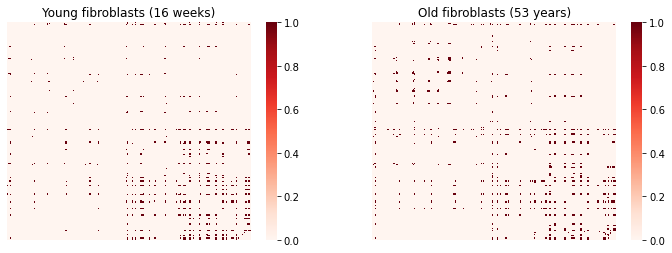

In [266]:
%matplotlib inline
diff.plot_binarized_maps(IMR90,old_fibroblasts)
plt.savefig(fig_dir + 'binarized_hic_BACH2.png')

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 432x288 with 0 Axes>

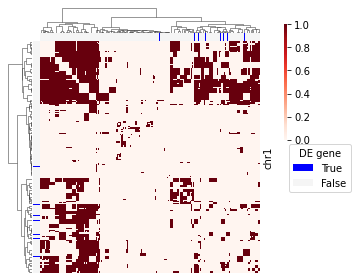

In [282]:
# Young fibroblast clustering
young_sub = IMR90.loc[(IMR90!=0).any(axis=1), (IMR90!=0).any(axis=1)]
diff.plot_clustered_anno(young_sub, selected_loci)

<Figure size 432x288 with 0 Axes>

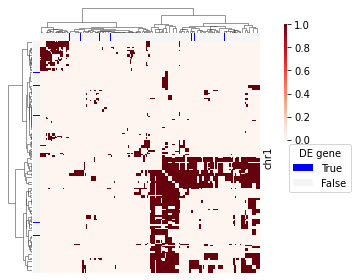

In [283]:
# Old fibroblast clustering
old_sub = old_fibroblasts.loc[(old_fibroblasts!=0).any(axis=1), (old_fibroblasts!=0).any(axis=1)]
diff.plot_clustered_anno(old_sub, selected_loci)

## b) Clustering of the difference matrix

In [284]:
# Differences between young and old
diff_map = IMR90 - old_fibroblasts

# Color map: including the similarities
color_map = IMR90 + 2 * old_fibroblasts


In [285]:
# Filter for loci that are contained in a LAS in at least one of the celltypes
color_map = color_map.loc[(color_map!=0).any(axis=1), (color_map!=0).any(axis=1)]
diff_map = diff_map.loc[color_map.index, color_map.index]

# Save results
color_map.to_csv(hic_dir + 'difference_maps/comp_map_BACH2_targets.csv')
diff_map.to_csv(hic_dir + 'difference_maps/diff_BACH2_targets.csv')

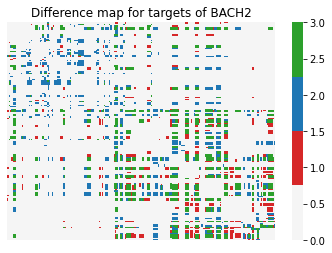

In [286]:
# Plot unclustered difference map
# define colors
palette = sns.color_palette("tab10")
colors = ['whitesmoke', palette[3], palette[0], palette[2]]
cmap = ListedColormap(colors)

plt.figure()
sns.heatmap(color_map, cmap = cmap, xticklabels=False, yticklabels=False)
plt.title("Difference map for targets of BACH2")
plt.ylabel("")

plt.savefig(fig_dir + 'difference_map_BACH2.png')
plt.show()

In [270]:
# Define distance metric for the color map (based on the number of differences in young and old)
def color_dist(l1, l2): # distance between a pair of loci
    if l1 == l2:
        diff = 0 
    elif (l1 == 0) & (l2 == 3):
        diff = 2
    elif (l1 == 3) & (l2 == 0):
        diff = 2
    elif (l1 == 1) & (l2 == 2):
        diff = 2
    elif (l1 == 2) & (l2 == 1):
        diff = 2
    else: 
        diff = 1
    return diff

def color_metric(r1, r2): # metric to calculate distance between two row vectors
    dist = [color_dist(r1[ix], r2[ix]) for ix in range(len(r1))]
    return np.mean(dist)

<Figure size 432x288 with 0 Axes>

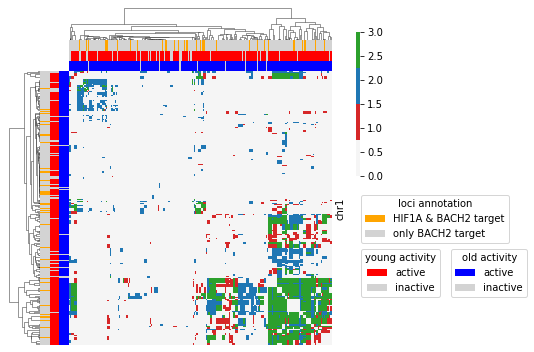

In [348]:
# Plot clustered differences with annotation for BACH2
# color annotation bar: HIF1A loci
HIF1A_loci = set(tf_targets.loc[tf_targets['TF'] == "HIF1A", 'locus'])
color_dict = {}
for loc in color_map.columns:
    if loc in HIF1A_loci:
        color_dict[loc] = 'orange'
    else:
        color_dict[loc] = 'lightgrey'
color_rows = pd.Series(color_dict)

# color annotation bar: loci activity
color_dict_y = {}
color_dict_o = {}
targets_activity = tf_targets[tf_targets['TF'] == "BACH2"]
targets_activity = targets_activity[['locus', 'young_activity', 'old_activity']].drop_duplicates()

for loc in color_map.columns:
    if targets_activity.loc[targets_activity['locus'] == loc, 'young_activity'].item() == "young:active":
        color_dict_y[loc] = 'red'
    else:
        color_dict_y[loc] = 'lightgrey'
        
    if targets_activity.loc[targets_activity['locus'] == loc, 'old_activity'].item() == "old:active":
        color_dict_o[loc] = 'blue'
    else:
        color_dict_o[loc] = 'lightgrey'
        
color_rows2 = pd.Series(color_dict_y)
color_rows3 = pd.Series(color_dict_o)

plt.figure()
p = sns.clustermap(color_map,
               method='complete',
               metric=color_metric,
               row_cluster=True, col_cluster=True,
               figsize=(5,5),
               xticklabels=False, yticklabels=False,
               cmap=cmap, cbar_pos=(1, 0.5, 0.01, .4),
               vmin=0, vmax=3,
               dendrogram_ratio=(.1, .1), 
               row_colors= [color_rows, color_rows2, color_rows3], col_colors = [color_rows, color_rows2, color_rows3])

# add legends for annotation bars
handles = [Patch(facecolor='orange'), Patch(facecolor='lightgrey')]
first_legend = plt.legend(handles, ['HIF1A & BACH2 target', 'only BACH2 target'], title='loci annotation',
           bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1., 0.3, 1., .102), loc='lower left')
ax = plt.gca().add_artist(first_legend)

handles = [Patch(facecolor='red'), Patch(facecolor='lightgrey')]
second_legend = plt.legend(handles, ['active', 'inactive'], title='young activity',
           bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1., 0.15, 1., .102), loc='lower left')
ax = plt.gca().add_artist(second_legend)

handles = [Patch(facecolor='blue'), Patch(facecolor='lightgrey')]
plt.legend(handles, ['active', 'inactive'], title='old activity',
           bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1.25, 0.15, 1., .102), loc='lower left')

plt.savefig(fig_dir+'clustered_diff_map_BACH2.png')
plt.show()

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [  2   8   1  42 136   2  12  24  48   6   6   7   4   4   2  14   4   1
  12   3   4   2  19]


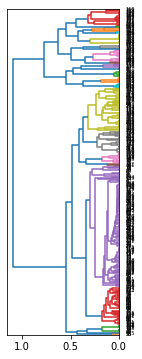

In [351]:
# Hierarchical clustering
# create dendrogram
dend = linkage(color_map, method='complete', metric=color_metric)
plt.figure(figsize = (2, 6))
dendrogram(dend, orientation = "left", color_threshold = 0.32)
plt.show()

clusters = fcluster(dend, 0.32, criterion = 'distance')
loci_clusters = pd.DataFrame({'locus': color_map.index, 'cluster': clusters})
loci_clusters['chrom'] = loci_clusters['locus'].str.split('_').str[1]
loci_clusters = loci_clusters.merge(selected_loci, how = "left", on = 'locus')
loci_clusters.to_csv(hic_dir + 'difference_maps/hierarchical_clusters_BACH2.csv', index = False)

unique, counts = np.unique(clusters, return_counts=True)
print(unique, counts)

In [325]:
# Enrichment of the loci in one cluster
loci = loci_clusters.loc[loci_clusters['cluster'] == 4, 'locus']
selected_genes = selected_loci.loc[selected_loci['locus'].isin(loci), 'gene']

# GSEA on old genes
enr = gseapy.enrichr(gene_list= selected_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='',  format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Cluster 16',
        cutoff=0.05, top_term=5, figsize=(7, 3), color='salmon')

2022-08-16 10:13:54,116 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


In [326]:
enr.results.head(5)

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,mitochondrion disassembly (GO:0061726),2/36,0.004564,0.214609,0,0,21.688453,116.892196,ULK1;SQSTM1,GO_Biological_Process_2021
1,autophagy of mitochondrion (GO:0000422),2/40,0.005610,0.214609,0,0,19.401559,100.561939,ULK1;SQSTM1,GO_Biological_Process_2021
2,endosome organization (GO:0007032),2/41,0.005887,0.214609,0,0,18.903134,97.066961,CLCN3;SQSTM1,GO_Biological_Process_2021
3,negative regulation of protein ubiquitination ...,2/51,0.008992,0.214609,0,0,15.037793,70.849602,PRR7;SQSTM1,GO_Biological_Process_2021
4,negative regulation of protein modification by...,2/55,0.010398,0.214609,0,0,13.900070,63.469174,PRR7;SQSTM1,GO_Biological_Process_2021


In [321]:
pd.Series([loc.split("_")[1] for loc in loci]).value_counts().rename_axis('chromosomes').reset_index(name='number of loci').transpose()

,0
chromosomes,17
number of loci,24


## c) Difference matrix as a graph

In [145]:
# Visualize heatmap as a graph (only expressed loci)
expression_clusters = pd.read_csv(hic_dir + 'difference_maps/BACH2_expression_clusters.csv')
expression_clusters = expression_clusters.merge(selected_loci, on = 'gene')
expression_clusters = expression_clusters[['cluster', 'locus']].drop_duplicates()
color_map = color_map.loc[color_map.columns.isin(expression_clusters['locus']), color_map.columns.isin(expression_clusters['locus'])]

# From numbers to labels
color_map = color_map.replace({0: 'no interaction', 1: 'young-specific interaction',
                              2: 'old-specific interaction', 3: 'common interaction'})

# To long format
diff_long = pd.melt(color_map.reset_index(), id_vars='chr1')
diff_long = diff_long[diff_long['value'] != 'no interaction']
diff_long.columns = ['loc1', 'loc2', 'diff']

network = nx.from_pandas_edgelist(diff_long, 'loc1', 'loc2', 'diff')

# add hierarchical clusters as node attributes
clusters_dict = {loci_clusters.loc[index, 'locus']: str(loci_clusters.loc[index, 'cluster']) for index in loci_clusters.index}
nx.set_node_attributes(network, clusters_dict, name='hierarchical-clusters')

# add Louvain clusters
partition = community.best_partition(network)
partition = {loc: str(cluster) for loc, cluster in partition.items()}
nx.set_node_attributes(network, partition, name='louvain-clusters')

# add chromosome number
chrom_number = {loc: loc.split("_")[1] for loc in color_map.columns}
nx.set_node_attributes(network, chrom_number, name='chromosome_number')

# add expression clusters
expr_dict = {loc: str(expression_clusters.loc[expression_clusters['locus'] == loc, 'cluster'].tolist()[0]) for loc in color_map.columns}
nx.set_node_attributes(network, expr_dict, name='expression_pattern_clusters')

oi.output_networkx_graph_as_interactive_html(network, filename=fig_dir + "diff_net_BACH2.html")

PosixPath('/home/braunger/masterthesis/save/figures/compare_hic/diff_net_BACH2.html')

In [41]:
# save louvain clusters
louvain_clusters = pd.DataFrame.from_dict(partition, orient='index').reset_index()
louvain_clusters.columns = ['locus', 'cluster']
louvain_clusters = louvain_clusters.merge(selected_loci, how = "left", on = 'locus')
louvain_clusters.to_csv(hic_dir + 'difference_maps/louvain_clusters_BACH2.csv', index = False)

In [87]:
louvain_clusters.head()

,locus,cluster,gene,DE
0,chr_4_loc_184250000,0,RN7SL28P,False
1,chr_6_loc_166250000,0,SFT2D1,False
2,chr_6_loc_166250000,0,RPS6KA2,False
3,chr_4_loc_185000000,0,SNX25,False
4,chr_1_loc_241250000,0,FH,False


In [96]:
# Enrichment of the loci in the clusters
selected_genes = louvain_clusters.loc[louvain_clusters['cluster'] == '0', 'gene']

# GSEA on old genes
enr = gseapy.enrichr(gene_list= selected_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='',  format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Cluster 5',
        cutoff=0.05, top_term=10, figsize=(7, 5), color='salmon')

2022-08-03 17:56:52,288 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


# 3. Comparison to random loci

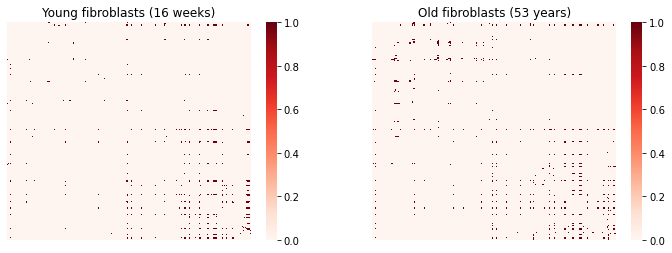

In [275]:
IMR90_random = pd.read_csv(hic_dir+'processed_hic_data_IMR90/binarized_maps/BACH2_random.csv', index_col = 0)
old_fibroblasts_random = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/binarized_maps/BACH2_random.csv', index_col = 0)

diff.plot_binarized_maps(IMR90_random, old_fibroblasts_random)
plt.savefig(fig_dir + 'binarized_hic_random.png')

In [259]:
# Differences between young and old
diff_map_random = IMR90_random - old_fibroblasts_random

# Color map: including the similarities
color_map_random = IMR90_random + 2 * old_fibroblasts_random

# Filter for loci that are contained in a LAS in at least one of the celltypes
color_map_random = color_map_random.loc[(color_map_random!=0).any(axis=1), (color_map_random!=0).any(axis=1)]
diff_map_random = diff_map_random.loc[color_map_random.index, color_map_random.index]

<Figure size 432x288 with 0 Axes>

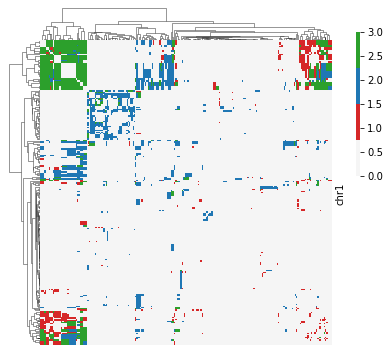

In [261]:
# Plot clustered differences 
plt.figure()
p = sns.clustermap(color_map_random,
               method='complete',
               metric=color_metric,
               row_cluster=True, col_cluster=True,
               figsize=(5,5),
               xticklabels=False, yticklabels=False,
               cmap=cmap, cbar_pos=(1, 0.5, 0.01, .4),
               vmin=0, vmax=3,
               dendrogram_ratio=(.1, .1))

#plt.savefig(fig_dir+'clustered_diff_map_random.png')
plt.show()

## Simulation with random loci: percentage of intermingling regions per celltype

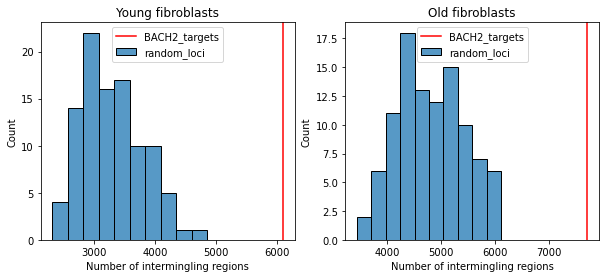

In [279]:
random_intermingling = pd.read_csv(hic_dir+'simulation_intermingling_random_loci.csv', index_col = 0)

fig, axs = plt.subplots(1, 2, figsize = (10, 4))

sns.histplot(random_intermingling, x="young", bins = 10, ax = axs[0], label = 'random_loci')
axs[0].set_title('Young fibroblasts')
axs[0].set_xlabel('Number of intermingling regions')
axs[0].axvline(x=IMR90.sum().sum()/2, color='red', label = 'BACH2_targets')
axs[0].legend()

sns.histplot(random_intermingling, x="old", bins = 10, ax = axs[1], label = 'random_loci')
axs[1].set_title('Old fibroblasts')
axs[1].set_xlabel('Number of intermingling regions')
axs[1].axvline(x=old_fibroblasts.sum().sum()/2, color='red', label = 'BACH2_targets')
axs[1].legend()

plt.savefig(fig_dir + 'significance_intermingling_BACH2.png')
plt.show()

## Simulation comparing intermingling percentage against the targets of non-included TFs

In [176]:
intermingling_selected_TFs, diff_selected_TFs = diff.get_TF_intermingling(['BACH2', 'HIF1A', 'STAT3'], 
                                                                          save_dir + 'TF_targets/', 
                                                                          hic_dir, 15, 30)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:11<00:00, 19.27it/s]


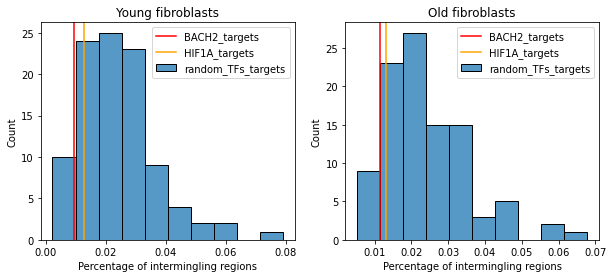

In [230]:
random_intermingling = pd.read_csv(hic_dir+'simulation_intermingling_non_incl_TFs.csv', index_col = 0)

fig, axs = plt.subplots(1, 2, figsize = (10, 4))

sns.histplot(random_intermingling, x="young", bins = 10, ax = axs[0], label = 'random_TFs_targets')
axs[0].set_title('Young fibroblasts')
axs[0].set_xlabel('Percentage of intermingling regions')
axs[0].axvline(x=intermingling_selected_TFs.loc['BACH2', 'young'], color='red', label = 'BACH2_targets')
axs[0].axvline(x=intermingling_selected_TFs.loc['HIF1A', 'young'], color='orange', label = 'HIF1A_targets')
axs[0].legend()

sns.histplot(random_intermingling, x="old", bins = 10, ax = axs[1], label = 'random_TFs_targets')
axs[1].set_title('Old fibroblasts')
axs[1].set_xlabel('Percentage of intermingling regions')
axs[1].axvline(x=intermingling_selected_TFs.loc['BACH2', 'old'], color='red', label = 'BACH2_targets')
axs[1].axvline(x=intermingling_selected_TFs.loc['HIF1A', 'old'], color='orange', label = 'HIF1A_targets')
axs[1].legend()

plt.savefig(fig_dir + 'significance_intermingling_BACH2_other_TFs.png')
plt.show()

## Simulation: percentages of differences

In [231]:
diff_random_TFs = pd.read_csv(hic_dir+'simulation_diff_non_incl_TFs.csv', index_col = 0)
diff_random_TFs.head()

,no_intermingling,young_specific,old_specific,shared
UBN1,0.993549,0.001245,0.002631,0.002575
LMNB1,0.976206,0.005480,0.007220,0.011094
DUX4,0.983956,0.003267,0.006991,0.005786
SNAI2,0.946956,0.014418,0.013617,0.025009
CBX3,0.970163,0.007169,0.008907,0.013761


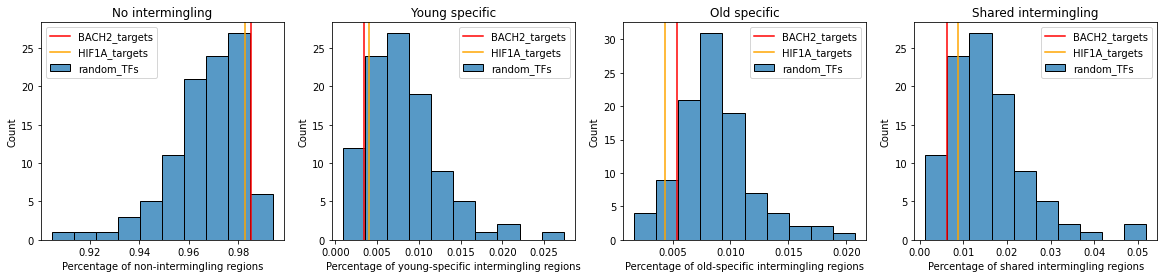

In [234]:
fig, axs = plt.subplots(1, 4, figsize = (20, 4))

sns.histplot(diff_random_TFs, x="no_intermingling", bins = 10, ax = axs[0], label = 'random_TFs')
axs[0].set_title('No intermingling')
axs[0].set_xlabel('Percentage of non-intermingling regions')
axs[0].axvline(x=diff_selected_TFs.loc['BACH2', 'no_intermingling'], color='red', label = 'BACH2_targets')
axs[0].axvline(x=diff_selected_TFs.loc['HIF1A', 'no_intermingling'], color='orange', label = 'HIF1A_targets')
#axs[0].axvline(x=diff_selected_TFs.loc['STAT3', 'no_intermingling'], color='green', label = 'STAT3_targets')
axs[0].legend()

sns.histplot(diff_random_TFs, x="young_specific", bins = 10, ax = axs[1], label = 'random_TFs')
axs[1].set_title('Young specific')
axs[1].set_xlabel('Percentage of young-specific intermingling regions')
axs[1].axvline(x=diff_selected_TFs.loc['BACH2', 'young_specific'], color='red', label = 'BACH2_targets')
axs[1].axvline(x=diff_selected_TFs.loc['HIF1A', 'young_specific'], color='orange', label = 'HIF1A_targets')
#axs[1].axvline(x=diff_selected_TFs.loc['STAT3', 'young_specific'], color='green', label = 'STAT3_targets')
axs[1].legend()

sns.histplot(diff_random_TFs, x="old_specific", bins = 10, ax = axs[2], label = 'random_TFs')
axs[2].set_title('Old specific')
axs[2].set_xlabel('Percentage of old-specific intermingling regions')
axs[2].axvline(x=diff_selected_TFs.loc['BACH2', 'old_specific'], color='red', label = 'BACH2_targets')
axs[2].axvline(x=diff_selected_TFs.loc['HIF1A', 'old_specific'], color='orange', label = 'HIF1A_targets')
#axs[2].axvline(x=diff_selected_TFs.loc['STAT3', 'old_specific'], color='green', label = 'STAT3_targets')
axs[2].legend()

sns.histplot(diff_random_TFs, x="shared", bins = 10, ax = axs[3], label = 'random_TFs')
axs[3].set_title('Shared intermingling')
axs[3].set_xlabel('Percentage of shared intermingling regions')
axs[3].axvline(x=diff_selected_TFs.loc['BACH2', 'shared'], color='red', label = 'BACH2_targets')
axs[3].axvline(x=diff_selected_TFs.loc['HIF1A', 'shared'], color='orange', label = 'HIF1A_targets')
#axs[3].axvline(x=diff_selected_TFs.loc['STAT3', 'shared'], color='green', label = 'STAT3_targets')
axs[3].legend()

plt.savefig(fig_dir + 'interaction_types_various_TFs.png')
plt.show()

In [235]:
# which of the random TFs have a very high percentage of young- and old-specific intermingling?
print(diff_random_TFs.sort_values('young_specific', ascending = False).head())
print(diff_random_TFs.sort_values('old_specific', ascending = False).head())
print(diff_random_TFs.sort_values('no_intermingling').head())

       no_intermingling  young_specific  old_specific    shared
HINFP          0.904807        0.027336      0.016044  0.051813
HOXA4          0.921647        0.021566      0.017239  0.039548
SP2            0.965374        0.019468      0.001693  0.013466
THAP1          0.939713        0.016860      0.009455  0.033971
MBD2           0.962579        0.015930      0.011782  0.009709
       no_intermingling  young_specific  old_specific    shared
RARA           0.960698        0.010523      0.020727  0.008052
ZMIZ1          0.955902        0.008304      0.018531  0.017264
HOXA4          0.921647        0.021566      0.017239  0.039548
E2F4           0.939231        0.013278      0.016547  0.030944
HINFP          0.904807        0.027336      0.016044  0.051813
       no_intermingling  young_specific  old_specific    shared
HINFP          0.904807        0.027336      0.016044  0.051813
HOXA4          0.921647        0.021566      0.017239  0.039548
RAC3           0.929201        0.013668 

In [229]:
number_of_targets = tf_targets['TF'].value_counts().rename_axis('TF').reset_index(name='n_targets')
number_of_targets[number_of_targets['TF'] == 'BDP1']
# --> all of the TFs with high percentages in young- or old-specific targets only have very few target genes

,TF,n_targets
380,BDP1,22


## Simulation: percentage of shared vs. specific intermingling

In [27]:
# TO DO: Compare to difference map of random loci
# what percentage of intermingling regions is shared, old-specific, young-specific?

In [104]:
shared = np.count_nonzero(np.array(color_map) == 'common interaction')
young_specific = np.count_nonzero(np.array(color_map) == 'young-specific interaction')
old_specific = np.count_nonzero(np.array(color_map) == 'old-specific interaction')

total_intermingling = shared + young_specific + old_specific
shared = shared / total_intermingling
young_specific = young_specific / total_intermingling
old_specific = old_specific / total_intermingling

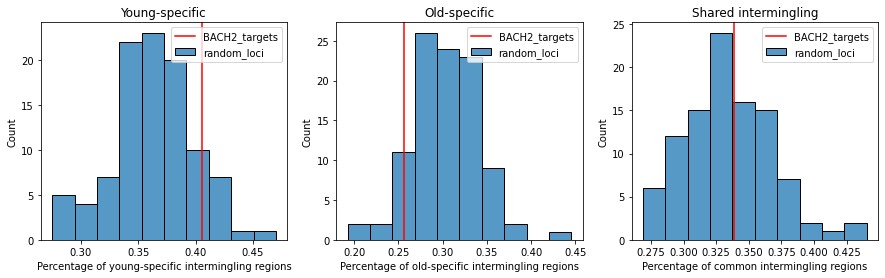

In [115]:
random_stats = pd.read_csv(hic_dir+'simulation_diff_random_loci.csv', index_col = 0)

fig, axs = plt.subplots(1, 3, figsize = (15, 4))

sns.histplot(random_stats, x="young_specific", bins = 10, ax = axs[0], label = 'random_loci')
axs[0].set_title('Young-specific')
axs[0].set_xlabel('Percentage of young-specific intermingling regions')
axs[0].axvline(x=young_specific, color='red', label = 'BACH2_targets')
axs[0].legend()

sns.histplot(random_stats, x="old_specific", bins = 10, ax = axs[1], label = 'random_loci')
axs[1].set_title('Old-specific')
axs[1].set_xlabel('Percentage of old-specific intermingling regions')
axs[1].axvline(x=old_specific, color='red', label = 'BACH2_targets')
axs[1].legend()

sns.histplot(random_stats, x="shared", bins = 10, ax = axs[2], label = 'random_loci')
axs[2].set_title('Shared intermingling')
axs[2].set_xlabel('Percentage of common intermingling regions')
axs[2].axvline(x=shared, color='red', label = 'BACH2_targets')
axs[2].legend()

plt.savefig(fig_dir + 'significance_percent_differences_BACH2.png')
plt.show()

# 4. Overlap of TF targets

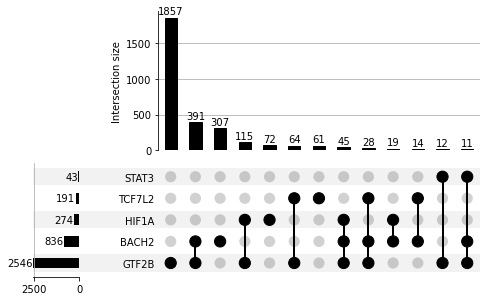

In [273]:
# load TFs that were analysed in more details
selected_TFs = ['BACH2','HIF1A','STAT3', 'GTF2B', 'TCF7L2']

# create dict and plot intersections
intersections_loci = from_contents(dict([(TF, set(tf_targets.loc[tf_targets['TF'] == TF, 'locus'])) 
                                    for TF in selected_TFs]))
upset = UpSet(intersections_loci, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 10).plot()
plt.savefig(fig_dir + 'target_loci_overlap.png')


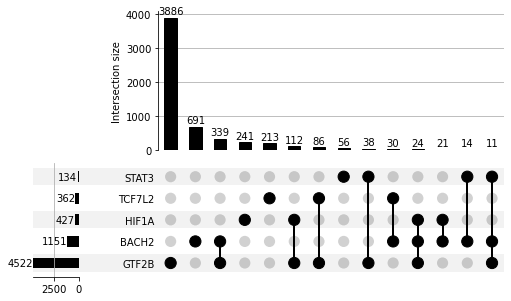

In [209]:
# plot intersection of target genes instead of loci
intersections_genes = from_contents(dict([(TF, set(tf_targets.loc[tf_targets['TF'] == TF, 'target'])) 
                                    for TF in shared_TFs]))
upset = UpSet(intersections_genes, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 10).plot()

In [214]:
# average number of targets per locus
TFs = ['BACH2','HIF1A','STAT3', 'GTF2B', 'TCF7L2', 'DUX4', 'RBPJ', 'ZC3H8', 'MEF2A']
[len(set(tf_targets.loc[tf_targets['TF'] == TF, 'target'])) / 
 len(set(tf_targets.loc[tf_targets['TF'] == TF, 'locus'])) for TF in TFs]
# --> selected TFs do not have more targets at the same locus than random TFs (the last four in the list)

[1.3767942583732058,
 1.5583941605839415,
 3.116279069767442,
 1.7761194029850746,
 1.8952879581151831,
 1.7287784679089027,
 2.231578947368421,
 2.0371517027863777,
 1.6236933797909407]

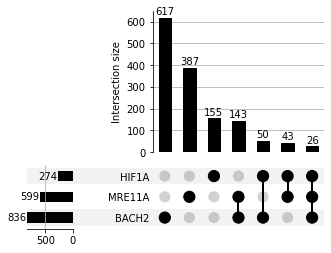

In [281]:
# load TFs that were analysed in more details
selected_TFs = ['BACH2','HIF1A','MRE11A']

# create dict and plot intersections
intersections_loci = from_contents(dict([(TF, set(tf_targets.loc[tf_targets['TF'] == TF, 'locus'])) 
                                    for TF in selected_TFs]))
upset = UpSet(intersections_loci, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 10).plot()
plt.savefig(fig_dir + 'target_loci_overlap_neg-control.png')
